# Ejemplo: probabilidad de temperaturas frias

En este tutorial vamos a explorar como generar una visualización de pronóstico:
- Vamos a elegir un dominio reducido
- Tomar datos diarios de temperatura mínima correspondiende a la semana 2 y aplicar el promedio
- Elegir un umbral de temperatura minina y calcular la probabilidad de que la temperatura mínima sea menor a ese umbral
- Graficar

In [2]:
# Como siempre, partimos importando los modulos a utilizar:
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
import xarray as xr
import s3fs
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
%matplotlib inline

Vamos a hacer este pronóstico para la semana del 28 de abril de 2016 al 4 de mayo de 2016 con dos pronósticos inicializados con una semana de diferencia. Vamos a elegir el umbral de temperatura mínima de 10 grados

In [3]:
variable = 'tmin'
umbral = 10
lat_n = -25
lat_s = -35
lon_w = -65
lon_e = -55
#fechas de inicializacion del pronostico
ref_date = [datetime.datetime.strptime('20160413', "%Y%m%d"), datetime.datetime.strptime('20160420', "%Y%m%d")] 

In [4]:
def preprocess_ds(ds, variable=variable):
    ds = ds.sel(lat=slice(lat_n, lat_s), lon=slice(lon_w, lon_e))
    ds = ds.assign_coords(M= int(ds[variable].encoding['source'][-6:-4]))
    ds = ds[variable]
    ds = ds.assign_coords(S = ds.time.values[0])
    ds['time'] = ds.time.values - ds.time.values[0]
    ds = ds.rename({'time': 'leadtime'})
    return ds
        

Vamos a buscar los datos para esas fechas y regiones

In [5]:
# DATOS CORREGIDOS
fs = s3fs.S3FileSystem(anon=True)
BUCKET_NAME = 'sissa-forecast-database'
tforecast = 'subseasonal'
modelo = 'GEFSv12_corr'
aux = []
for i in ref_date:
    PATH = tforecast + '/' + modelo + '/' + variable + '/' + i.strftime('%Y') + '/' + i.strftime('%Y%m%d') + '/'            
    remote_files = fs.glob('s3://' + BUCKET_NAME + '/' + PATH + '*.nc')
    # Iterate through remote_files to create a fileset
    fileset = [fs.open(file) for file in remote_files]
    # This works
    data = xr.open_mfdataset(fileset, combine='nested', concat_dim='M', preprocess=preprocess_ds)
    aux.append(data)

ds = xr.concat(aux, dim='S')
print(ds)


<xarray.DataArray 'tmin' (S: 2, M: 11, leadtime: 34, lat: 41, lon: 41)>
dask.array<concatenate, shape=(2, 11, 34, 41, 41), dtype=float64, chunksize=(1, 1, 1, 41, 41), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float64 -25.0 -25.25 -25.5 -25.75 ... -34.5 -34.75 -35.0
  * lon       (lon) float64 -65.0 -64.75 -64.5 -64.25 ... -55.5 -55.25 -55.0
  * M         (M) int64 0 1 2 3 4 5 6 7 8 9 10
  * S         (S) datetime64[ns] 2016-04-13 2016-04-20
  * leadtime  (leadtime) timedelta64[ns] 0 days 1 days ... 32 days 33 days
Attributes:
    standard_name:  min_air_temperature
    units:          Celsius
    long_name:      min temperature at 2m 0-23 UTC


Selecciono la semana del 28 de abril al 4 de mayo y calculo la probabilidad de que la temperatura media en esa semana sea menor al umbral para los pronósticos iniciados en las dos fechas elegidas

In [10]:
prob = []
for i in ds.S.values:
    aux = (ds.sel(S=i, leadtime = slice(np.datetime64('2016-04-28', '[D]') - i, np.datetime64('2016-05-04', '[D]') - i)).mean('leadtime', skipna=True) < umbral).sum('M') / len(ds.M.values) * 100
    prob.append(aux)
prob = xr.concat(prob, dim='S').compute()

Graficamos las probabilidades

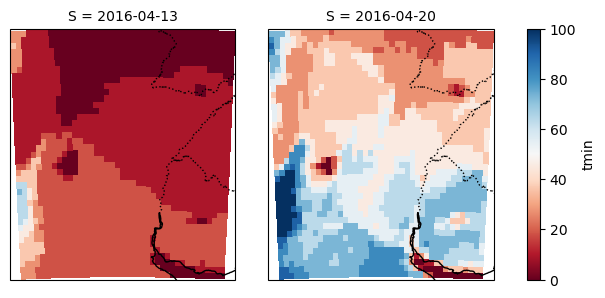

In [8]:
p = prob.plot(col='S', cmap='RdBu', subplot_kws={"projection": ccrs.Orthographic(-60, -30)}, transform=ccrs.PlateCarree())

for ax in p.axs.flat:
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='black')

Ahora descargamos los datos para esa semana de era 5 y la graficamos

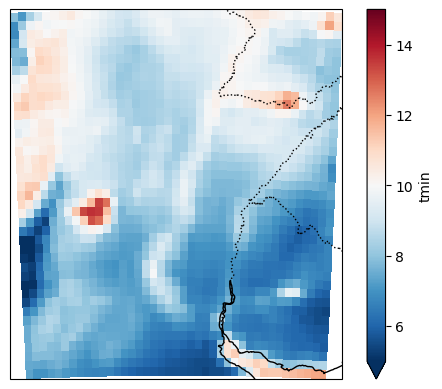

In [9]:
# Obtenemos los datos de ERA5
fs = s3fs.S3FileSystem(anon=True)
BUCKET_NAME = 'sissa-forecast-database'
tforecast = 'ERA5'
modelo = 'ERA5'
list_df = []
PATH = tforecast + '/' + variable 
awsfile = fs.ls('s3://' + BUCKET_NAME + '/' + PATH + '/2016.nc')
with fs.open(awsfile[0]) as f:
    era = xr.open_dataset(f)
    era = era.sel(latitude=slice(lat_n, lat_s), longitude=slice(lon_w, lon_e), time=slice('2016-04-28', '2016-05-04')).mean('time')
    p = era[variable].plot(cmap='RdBu_r', subplot_kws={"projection": ccrs.Orthographic(-60, -30)}, transform=ccrs.PlateCarree(), vmin=5, vmax=15)
    p.axes.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='black')
    p.axes.coastlines()